# CitiBike 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

In [3]:
files = glob.glob('data/*.csv')
df = pd.DataFrame()
for file in files:
    df_tmp = pd.read_csv(file)
    df = pd.concat([df, df_tmp])

In [5]:
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,681,2018-08-01 00:00:07.3210,2018-08-01 00:11:28.9920,3162.0,W 78 St & Broadway,40.783400,-73.980931,3383.0,Cathedral Pkwy & Broadway,40.804213,-73.966991,27770,Subscriber,1986,1
1,625,2018-08-01 00:00:19.7480,2018-08-01 00:10:45.0290,3260.0,Mercer St & Bleecker St,40.727064,-73.996621,2012.0,E 27 St & 1 Ave,40.739445,-73.976806,25938,Subscriber,1969,1
2,1319,2018-08-01 00:00:21.1750,2018-08-01 00:22:20.6370,403.0,E 2 St & 2 Ave,40.725029,-73.990697,285.0,Broadway & E 14 St,40.734546,-73.990741,28679,Subscriber,1970,1
3,220,2018-08-01 00:00:26.4700,2018-08-01 00:04:06.8190,3637.0,Fulton St & Waverly Ave,40.683239,-73.965996,399.0,Lafayette Ave & St James Pl,40.688515,-73.964763,28075,Subscriber,1982,1
4,398,2018-08-01 00:00:30.2910,2018-08-01 00:07:09.2810,3662.0,31 Ave & Steinway St,40.761294,-73.916917,3517.0,31 St & Hoyt Ave N,40.771153,-73.917007,25002,Subscriber,1987,1


In [7]:
df.describe()

,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,birth year,gender
count,1.754834e+07,1.754584e+07,1.754834e+07,1.754834e+07,1.754584e+07,1.754834e+07,1.754834e+07,1.754834e+07,1.754834e+07,1.754834e+07
mean,9.887432e+02,1.589282e+03,4.073737e+01,-7.398260e+01,1.580830e+03,4.073704e+01,-7.398281e+01,2.656141e+04,1.978993e+03,1.148613e+00
std,1.889584e+04,1.439432e+03,3.225813e-02,1.912753e-02,1.438502e+03,3.206583e-02,1.919611e-02,6.222916e+03,1.192922e+01,5.438043e-01
min,6.100000e+01,7.200000e+01,4.064654e+01,-7.402535e+01,7.200000e+01,4.064654e+01,-7.408364e+01,1.452900e+04,1.885000e+03,0.000000e+00
25%,3.580000e+02,3.800000e+02,4.071755e+01,-7.399521e+01,3.800000e+02,4.071755e+01,-7.399595e+01,2.029300e+04,1.969000e+03,1.000000e+00
50%,6.050000e+02,5.050000e+02,4.073818e+01,-7.398565e+01,5.050000e+02,4.073756e+01,-7.398602e+01,2.827000e+04,1.981000e+03,1.000000e+00
75%,1.060000e+03,3.249000e+03,4.075763e+01,-7.397283e+01,3.249000e+03,4.075725e+01,-7.397344e+01,3.185200e+04,1.989000e+03,1.000000e+00
max,1.951005e+07,3.721000e+03,4.550636e+01,-7.356891e+01,3.721000e+03,4.550636e+01,-7.356891e+01,3.583100e+04,2.002000e+03,2.000000e+00


## Raised Questions
* In order to predict future number of trips, What factors effect ?
* Does the trip duration has any correlation with other variables ?
* Does 

In [9]:
df.starttime = pd.to_datetime(df.starttime)

## Univariate Exploration

In [17]:
base_color = sns.color_palette()[0]

(0, 5000)

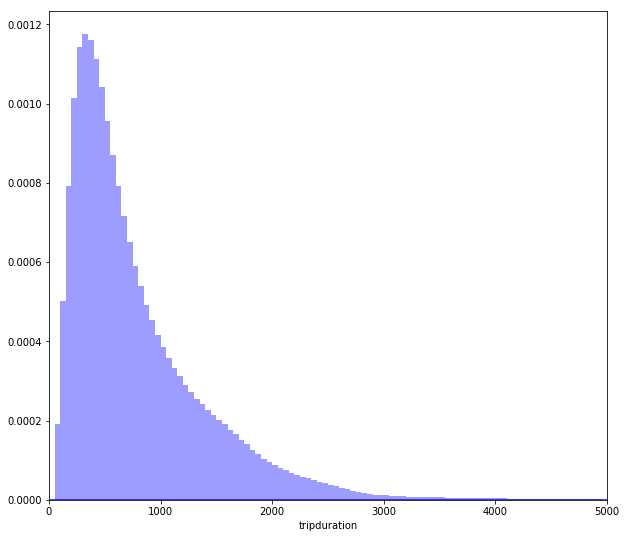

In [20]:
plt.figure(figsize=(10,9))
bins = np.arange(0, 5000, 50)
sns.distplot(df.tripduration, bins=bins, color='#0B0BFF');
plt.xlim(0,5000)

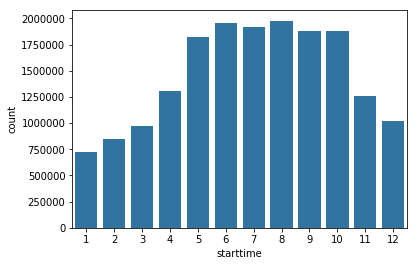

In [21]:
sns.countplot(df.starttime.dt.month, color=base_color);

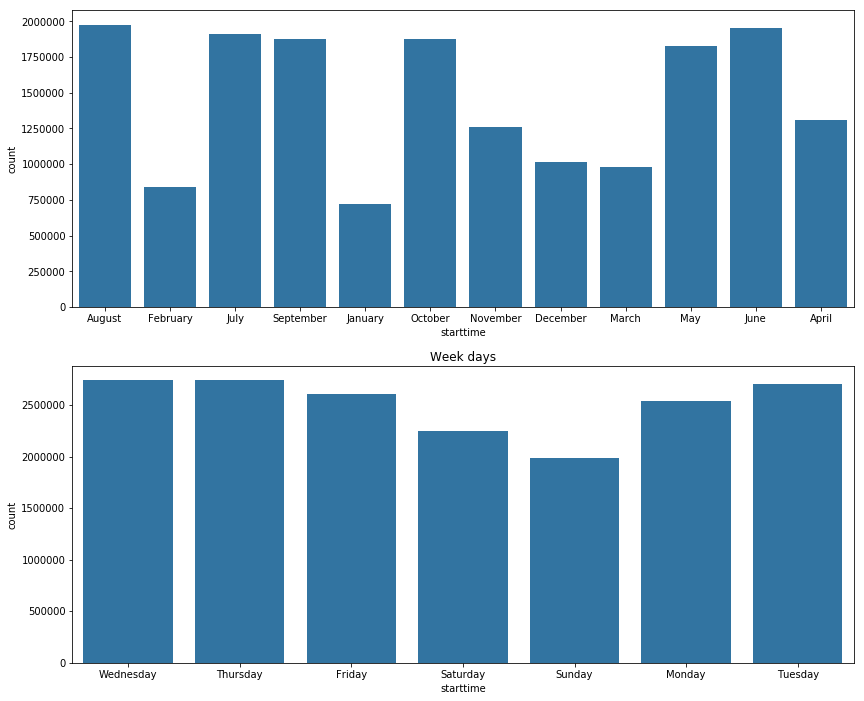

In [22]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14,12))

sns.countplot(df.starttime.dt.month_name(), color=base_color, ax=ax[0]);
plt.title('month')

sns.countplot(df.starttime.dt.day_name(), color=base_color, ax=ax[1]);
plt.title('Week days')

plt.show()

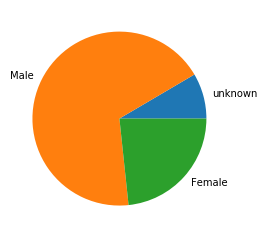

In [28]:
label = ['unknown', 'Male', 'Female']
gender_grouped = df.groupby('gender').size()
plt.pie(gender_grouped ,labels=label);

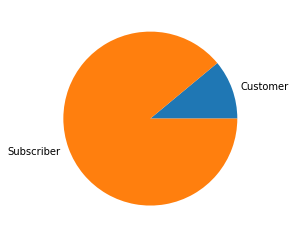

In [29]:
gender_grouped = df.groupby('usertype').size()
plt.pie(gender_grouped, labels=gender_grouped.index);

(1940, 2007)

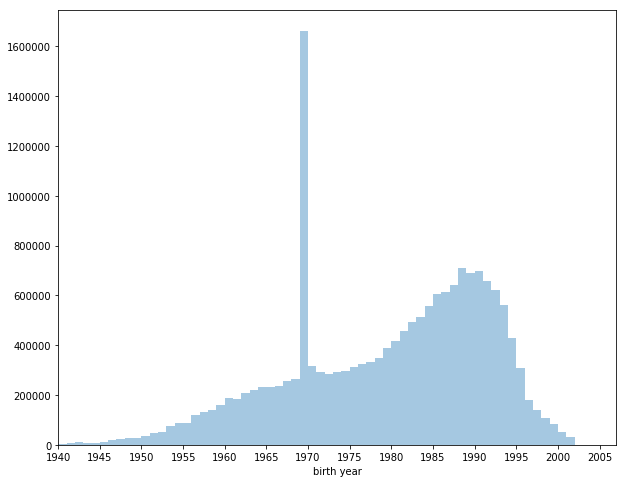

In [59]:
plt.figure(figsize=(10,8))
base_color = sns.color_palette()[0]
max_birth = df['birth year'].max()
bins = np.arange(1940, max_birth + 1, 1)
labels=np.arange(1940, max_birth + 5, 5)
sns.distplot(df['birth year'],bins=bins,kde=False, color=base_color);
plt.xticks(labels);
plt.xlim(1940, max_birth + 5)

The shape is sekead to left, with one big spike in year 1969.
After futhur investigaion, I found many customers sigend with 1969 birth year. This might be cuased by someone filled Null values with this specfic year.<br>
This quality issue must be solved to pr********

In [28]:
year_1970 = (df['birth year'] == 1970).sum().compute()
year_1968 = (df['birth year'] == 1968).sum().compute()
avg = (year_1968 + year_1970) / 2

year_1969 = (df['birth year'] == 1969).sum().compute()
year_1969 - avg

1374508.0

(1940, 2007)

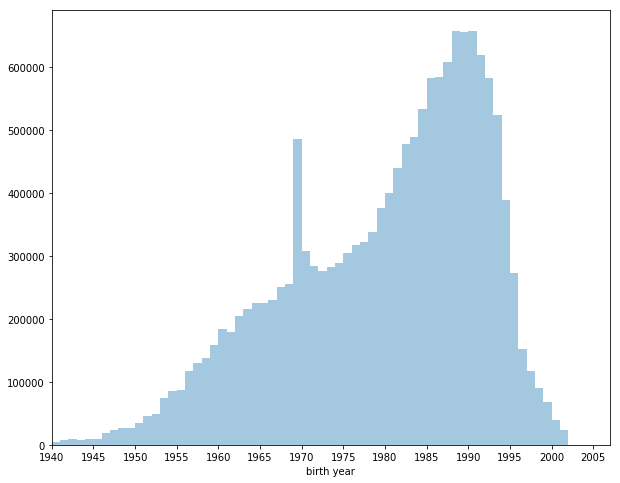

In [67]:
plt.figure(figsize=(10,8))
base_color = sns.color_palette()[0]
max_birth = df['birth year'].max().compute()
bins = np.arange(1940, max_birth + 1, 1)
labels=np.arange(1940, max_birth + 5, 5)
sns.distplot(df[df.usertype == 'Subscriber']['birth year'].compute(),bins=bins,kde=False, color=base_color);
plt.xticks(labels);
plt.xlim(1940, max_birth + 5)

## Bivirate exploration

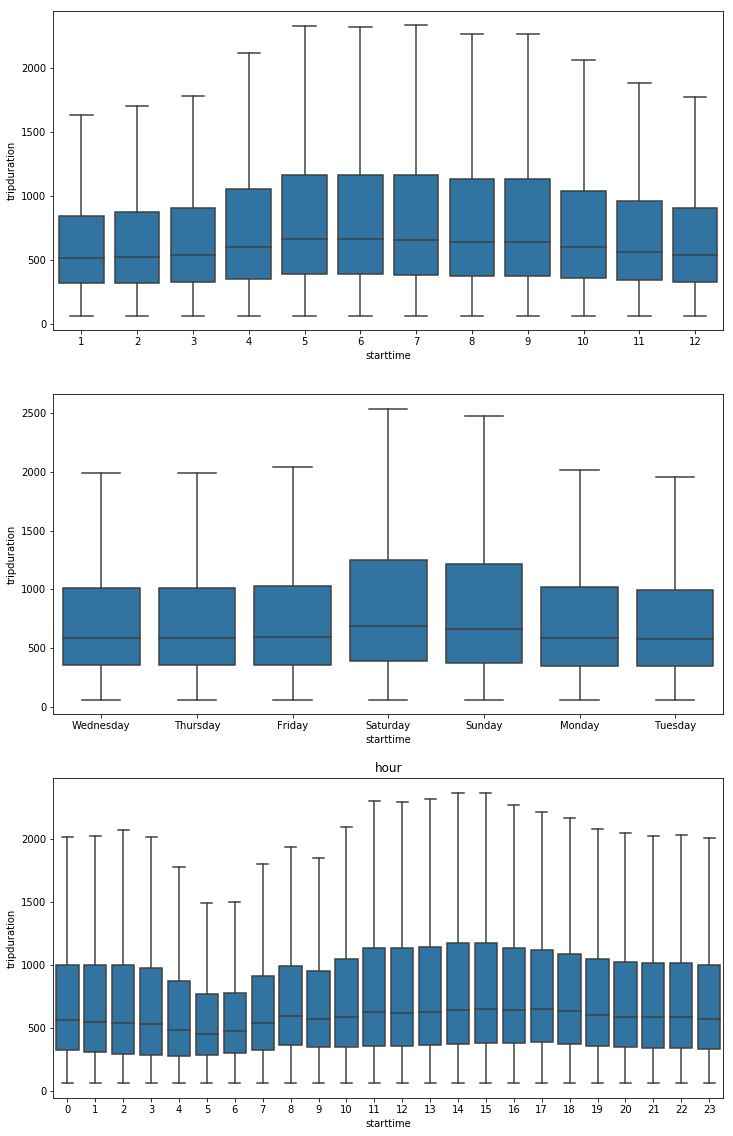

In [31]:
fig, ax = plt.subplots(nrows=3, figsize=(12,20))

plt.title('month')
sns.boxplot(df.starttime.dt.month, df.tripduration, showfliers=False, color=base_color, ax=ax[0])

plt.title('week day')
sns.boxplot(df.starttime.dt.day_name(), df.tripduration, showfliers=False, color=base_color, ax=ax[1])

plt.title('hour')
sns.boxplot(df.starttime.dt.hour, df.tripduration, showfliers=False, color=base_color, ax=ax[2])

plt.show()

/home/srap/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


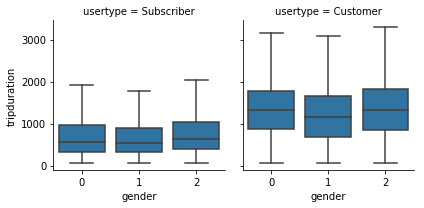

In [37]:
g = sns.FacetGrid(col='usertype', data=df)
g.map(sns.boxplot, 'gender', 'tripduration', data=df, color=base_color, showfliers=False);

In [ ]:
sns.lineplot('tripduration', '')